In [51]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
from scipy.signal import find_peaks
import subprocess
import pandas as pd
import re
import nd2
from skimage.measure import regionprops

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


In [2]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')


# Cell Fluoresence Retrieval

In [62]:
#script = f'POSIX path of (choose folder default location "{current_directory}")'
#selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()
#nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]
#selected_folder = os.path.normpath('D:\Lab Analysis PC\Test Stacks')
one_stack_folder = os.path.join(parent_directory, 'one stack')
nd2_files = [f for f in os.listdir(one_stack_folder) if f.endswith('.nd2')]
#nd2_files = [f for f in os.listdir(os.path.normpath('D:\Lab Analysis PC\Test Stacks')) if f.endswith('.nd2')]

### Model Paths ###
model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
model_path_wga = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')

all_data = pd.DataFrame()
unid_counter = 0

# FOR TESTING
#nd2_files = ['2007R_GLUT1_647_WGA_594_0002.nd2']

# Initialize models outside the loop if they remain constant
deblur_model = denoise.CellposeDenoiseModel(gpu=True, model_type=model_path_dapi, restore_type="deblur_cyto3")
wga_model = models.CellposeModel(gpu=True, pretrained_model=model_path_wga)

for nd2_file in nd2_files:

    # 1) Download Image Data
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(one_stack_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = to_8bit(f.asarray())

    # 2) DAPI max projection, Deblur, Segment
    DAPI_stack = image[:, 0, :, :].copy()
    mp_DAPI = max_proj(DAPI_stack)

    # 3) Deblur and Segment DAPI max projection
    DAPI_masks, flows, styles, image_deblurred = deblur_model.eval(auto_brightness_contrast(mp_DAPI), diameter=None, channels=[0, 0])
    image_deblurred = image_deblurred[:, :, 0]  # resulting image has one channel, but it still needs to be indexed

    # DAPI filtering and eGFP identification
    coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)
    filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d, num_closest_points=15, z_threshold=2)
    filtered_DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)
    DAPI_masks = filtered_DAPI_masks.copy()

    coords_2d = [(i[0], i[1]) for i in filtered_coords_3d]
    in_rip_dict = rip_identifier(nd2_file, image, DAPI_masks, coords_2d)

    # List for eGFP identification later
    eGFP_fluorescence_list = []
    
    # Initialize a list to accumulate cell data
    file_data_list = []

    '''
    Indiviudal Cell
    '''

    # 5) Segmentation of WGA channel
    mask_idxs = np.delete(np.unique(DAPI_masks), 0) - 1

    for mask_id in mask_idxs:

        single_mask = extract_masks(DAPI_masks, mask_id)
        diam = get_mask_diameter(single_mask)
        expansion = 50

        sq_stacks = get_sq_stacks(image, single_mask)

        # Running the model of the expanded squares
        expanded_sq_WGA, z_level = extract_square_proj_expand(image, single_mask, expansion)

        expanded_mask, flows, styles = wga_model.eval(expanded_sq_WGA, diameter=diam, channels=[0, 0])

        # Removing 0-pixel boundary and finding the largest mask in the array
        WGA_mask = remove_boundary(expanded_mask, expansion)

        if len(np.unique(WGA_mask)) == 1:
            print('No mask found.')
            continue

        # Examine this
        largest_idx = np.argmax(utils.diameters(WGA_mask)[1])
        WGA_mask = extract_masks(WGA_mask, largest_idx)

        # Z-axis profile
        trace_results = get_traces(sq_stacks, WGA_mask)

        # eGFP extraction
        eGFP_sum = np.sum(sq_stacks[1, z_level, :, :][(WGA_mask.astype(bool))])
        eGFP_sum_area_normalized = eGFP_sum / np.sum(WGA_mask)

        eGFP_fluorescence_list.append((mask_id, eGFP_sum_area_normalized))

        '''
        Organizing data
        '''

        # 6) Converting trace results into a pd dataframe
        cell_data = organize_data(trace_results, mask_id)

        # 7) Adding file information
        djid, eye, file_base = extract_information(nd2_file)

        nested_array = np.array(range(image.shape[0])) * z_sep
        cell_data['X_vals'] = [nested_array for i in range(len(cell_data))]
        cell_data['file_name'] = file_base
        cell_data['DJID'] = djid
        cell_data['Eye'] = eye
        cell_data['eGFP_Value'] = False

        # Adding in_rip information
        cell_data['in_rip'] = False

        for file_name, mask_ids in in_rip_dict.items():
            if file_name == file_base and mask_id in mask_ids:
                cell_data['in_rip'] = True

        # Accumulating cell data
        file_data_list.append(cell_data)

    # Concatenating the list into a single DataFrame for the file
    file_data = pd.concat(file_data_list, ignore_index=True)

    # Processing eGFP data for the entire file
    eGFP_idxs = np.array([i[0] for i in eGFP_fluorescence_list])
    eGFP_vals = np.array([i[1] for i in eGFP_fluorescence_list])

    # Normalizing eGFP values
    eGFP_vals_normal = normalize(eGFP_vals)

    # Setting cells above .2 as positive
    eGFP_pos_idxs = eGFP_idxs[eGFP_vals_normal > .2]
    file_data.loc[file_data['mask_id'].isin(eGFP_pos_idxs), 'eGFP_Value'] = True
    file_data['eGFP_Raw_Intensity'] = eGFP_vals

    # Accumulating data at the all_data level
    all_data = pd.concat([all_data, file_data], ignore_index=True)


INFO:cellpose.denoise:>> deblur_cyto3 << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.denoise:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> loading model d:\Lab Analysis PC\ImageAnalysis/cellpose_models/T5_DAPI_V3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:>>>> model diam_labels =  70.918 (mean diameter of training ROIs)
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> loading model d:\Lab Analysis PC\ImageAnalysis/cellpose_models/T5_WGA_V2
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:>>>> model diam_labels =  59.384 (me

Processing 2007R_GLUT1_647_WGA_594_0002.nd2
No mask found.
No mask found.


INFO:cellpose.dynamics:No cell pixels found.


No mask found.
Processing 3203R_GLUT1_647_WGA_594_0002.nd2


C:\Users\Luis\AppData\Local\Temp\ipykernel_7664\475263720.py:29: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)


No mask found.


In [65]:
all_data['X_vals'] = all_data['X_vals'].apply(lambda x: ', '.join(map(str, x)))
all_data['Y_vals'] = all_data['Y_vals'].apply(lambda x: ', '.join(map(str, x)))
all_data.to_csv('all_data.csv', index = False)

In [55]:
all_data


Y_vals  mask_id  Stain  \
0    [88231, 88395, 89662, 90581, 92721, 93422, 942...        0   DAPI   
1    [12355, 12520, 12597, 12537, 12876, 13175, 132...        0   eGFP   
2    [36257, 36092, 38264, 41798, 46942, 55160, 596...        0    WGA   
3    [3717, 3686, 3944, 4754, 5774, 7369, 7972, 100...        0  GluT1   
4    [109662, 110592, 111608, 113614, 115944, 11889...        1   DAPI   
..                                                 ...      ...    ...   
831  [2123, 2449, 3118, 3544, 4692, 6903, 8119, 107...       87  GluT1   
832  [42556, 42943, 44358, 44652, 46387, 48735, 490...       88   DAPI   
833  [8789, 9306, 10037, 10463, 11793, 13583, 14484...       88   eGFP   
834  [20568, 22678, 26985, 30407, 41238, 60169, 706...       88    WGA   
835  [1208, 1430, 1976, 2546, 3336, 4560, 5167, 680...       88  GluT1   

                                                X_vals  \
0    [ 0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1....   
1    [ 0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1....   
2    [ 0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1....   
3    [ 0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1....   
4    [ 0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1....   
..                                                 ...   
831  [0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2...   
832  [0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2...   
833  [0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2...   
834  [0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2...   
835  [0. 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2...   

                        file_name  DJID Eye  eGFP_Value  in_rip  
0    2007R_GLUT1_647_WGA_594_0002  2007   R       False   False  
1    2007R_GLUT1_647_WGA_594_0002  2007   R       False   False  
2    2007R_GLUT1_647_WGA_594_0002  2007   R       False   False  
3    2007R_GLUT1_647_WGA_594_0002  2007   R       False   False  
4    2007R_GLUT1_647_WGA_594_0002  2007   R       False   False  
..                            ...   ...  ..         ...     ...  
831  3203R_GLUT1_647_WGA_594_0002  3203   R       False   False  
832  3203R_GLUT1_647_WGA_594_0002  3203   R        True   False  
833  3203R_GLUT1_647_WGA_594_0002  3203   R        True   False  
834  3203R_GLUT1_647_WGA_594_0002  3203   R        True   False  
835  3203R_GLUT1_647_WGA_594_0002  3203   R        True   False  

[836 rows x 9 columns]

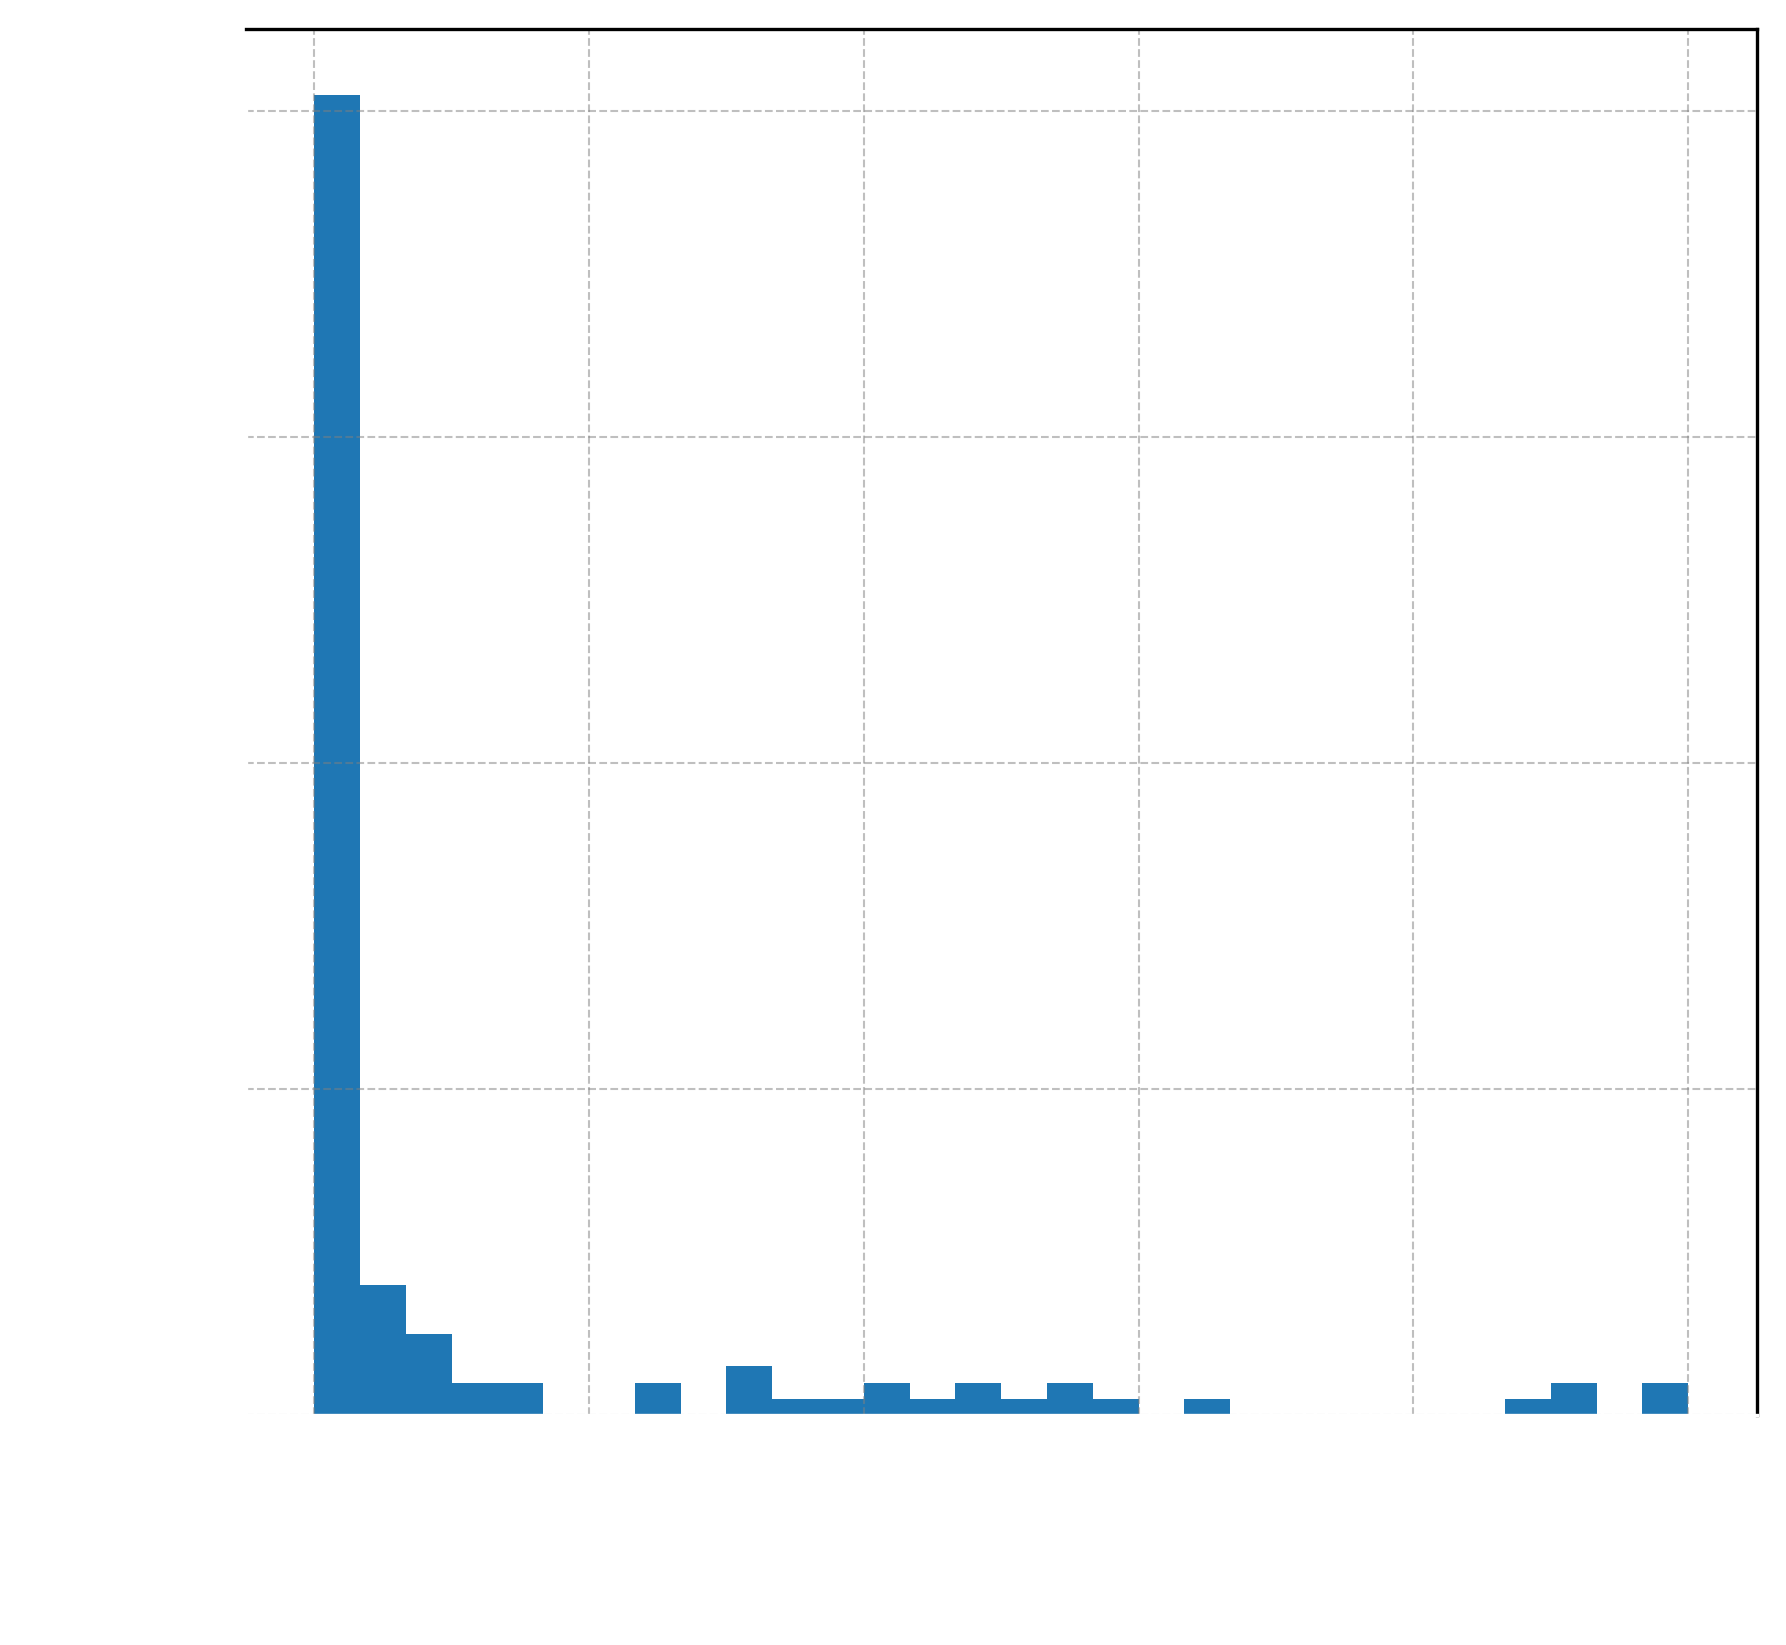

In [88]:
# Set the figure dimensions and font sizes
fig_width = 6.5     # width in inches
fig_height = 6    # height in inches
font_size = 20   # base font size
label_size = 20   # label font size
title_size = 20   # title font size

# Create the figure and axis with specified dimensions
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Set the font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# Set the number of bins for the histogram
bins_num = 30

# Plot the histogram
ax.hist(eGFP_vals_normal, bins=bins_num)

# Add annotation with specified font size
ax.annotate(f'bins = {str(bins_num)}', (70, 80), color='white', fontsize=font_size)

# Set labels with white color and specified font sizes
ax.set_xlabel('Fluorescence/Area Normalized', color='white', fontsize=label_size)
ax.set_ylabel('Cell Count', color='white', fontsize=label_size)

# Set the tick parameters for white ticks and specified font size
ax.tick_params(colors='white', labelsize=font_size)

# Set the bottom and left axis lines to white
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Set the top and right axis lines to black
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')

# Add faint grey grid lines
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

# Set the background of the figure to transparent
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

# Show the plot
plt.show()


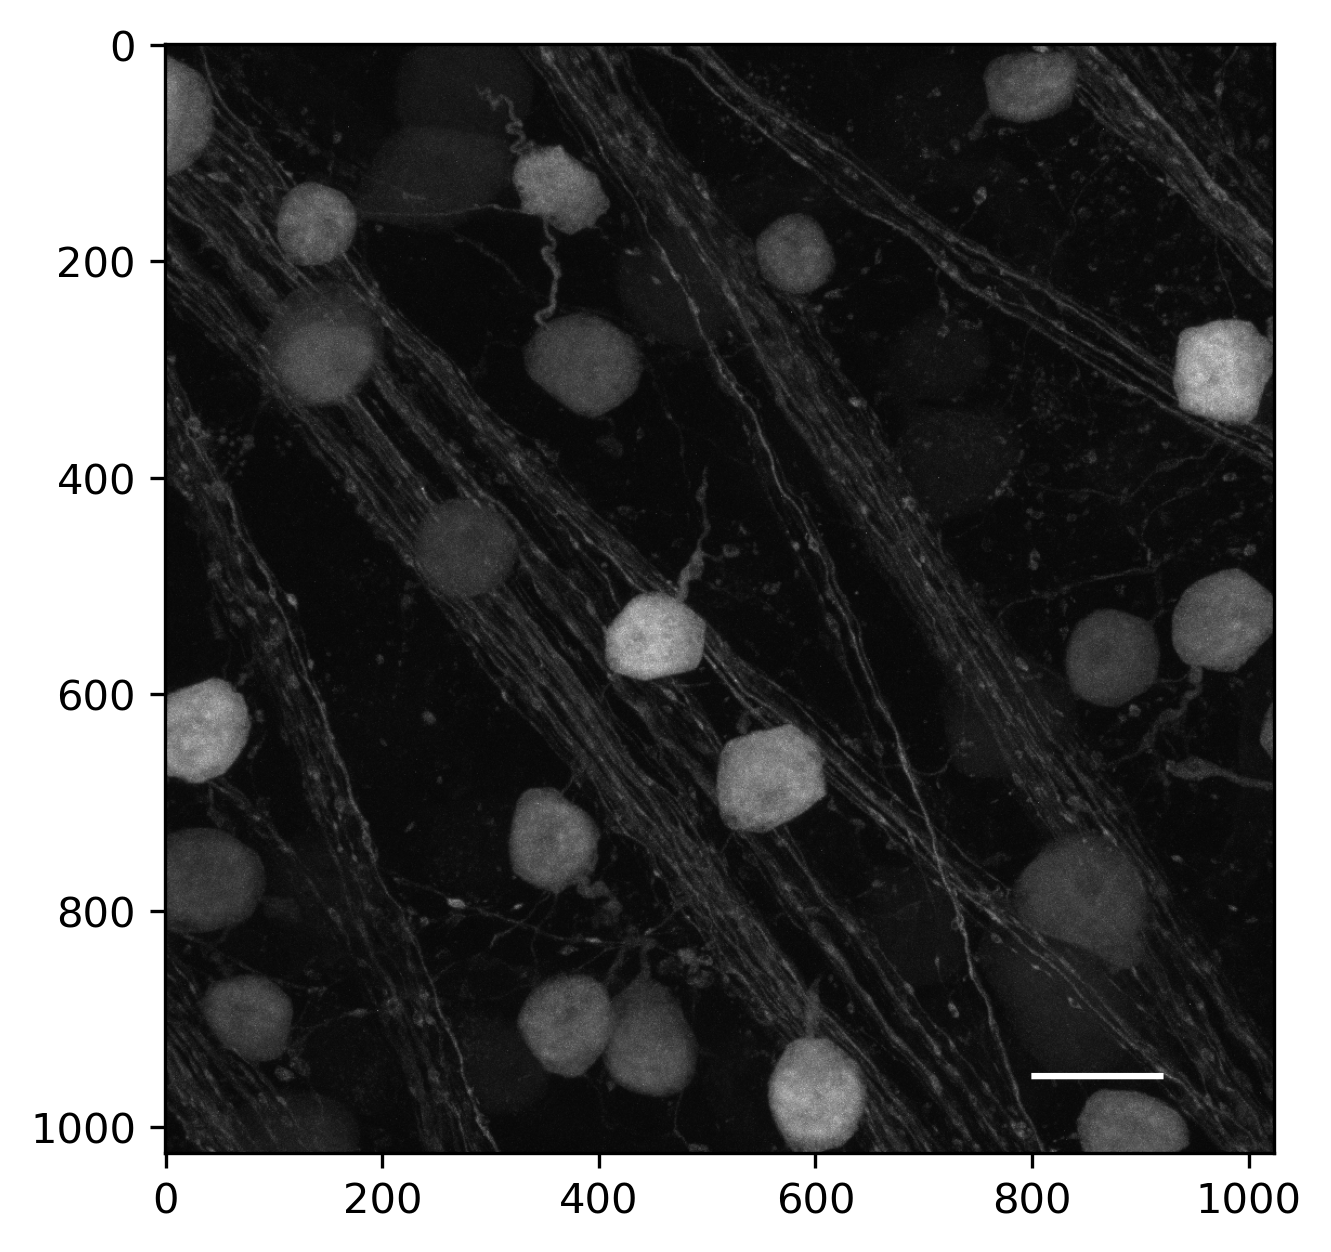

In [79]:
eGFP_mp = grey_to_color(max_proj(image[:, 1, :, :]), 'white')
plt.imshow(add_scale_bar(eGFP_mp, .123, 15, 800, 950))

(-0.5, 1023.5, 1023.5, -0.5)

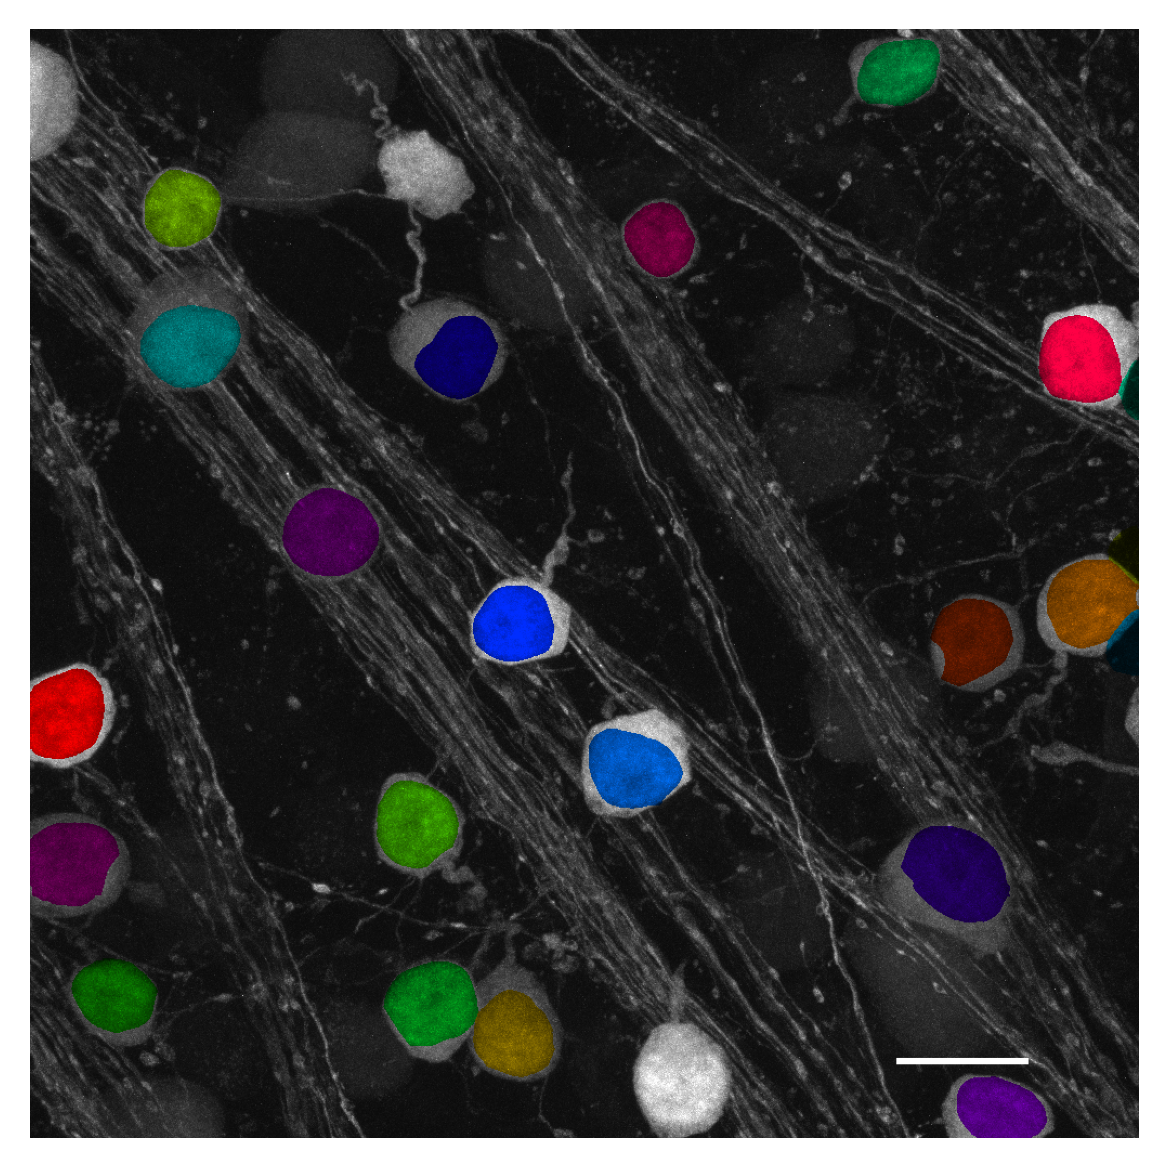

In [90]:
overlay = plot.mask_overlay(max_proj(image[:, 1, :, :]),
                            extract_masks(DAPI_masks, np.array([i[0] for i in  eGFP_fluorescence_list])[np.array([i[1] for i in  eGFP_fluorescence_list]) > 20]))
plt.imshow(add_scale_bar(overlay, .123, 15, 800, 950))
plt.axis('off')

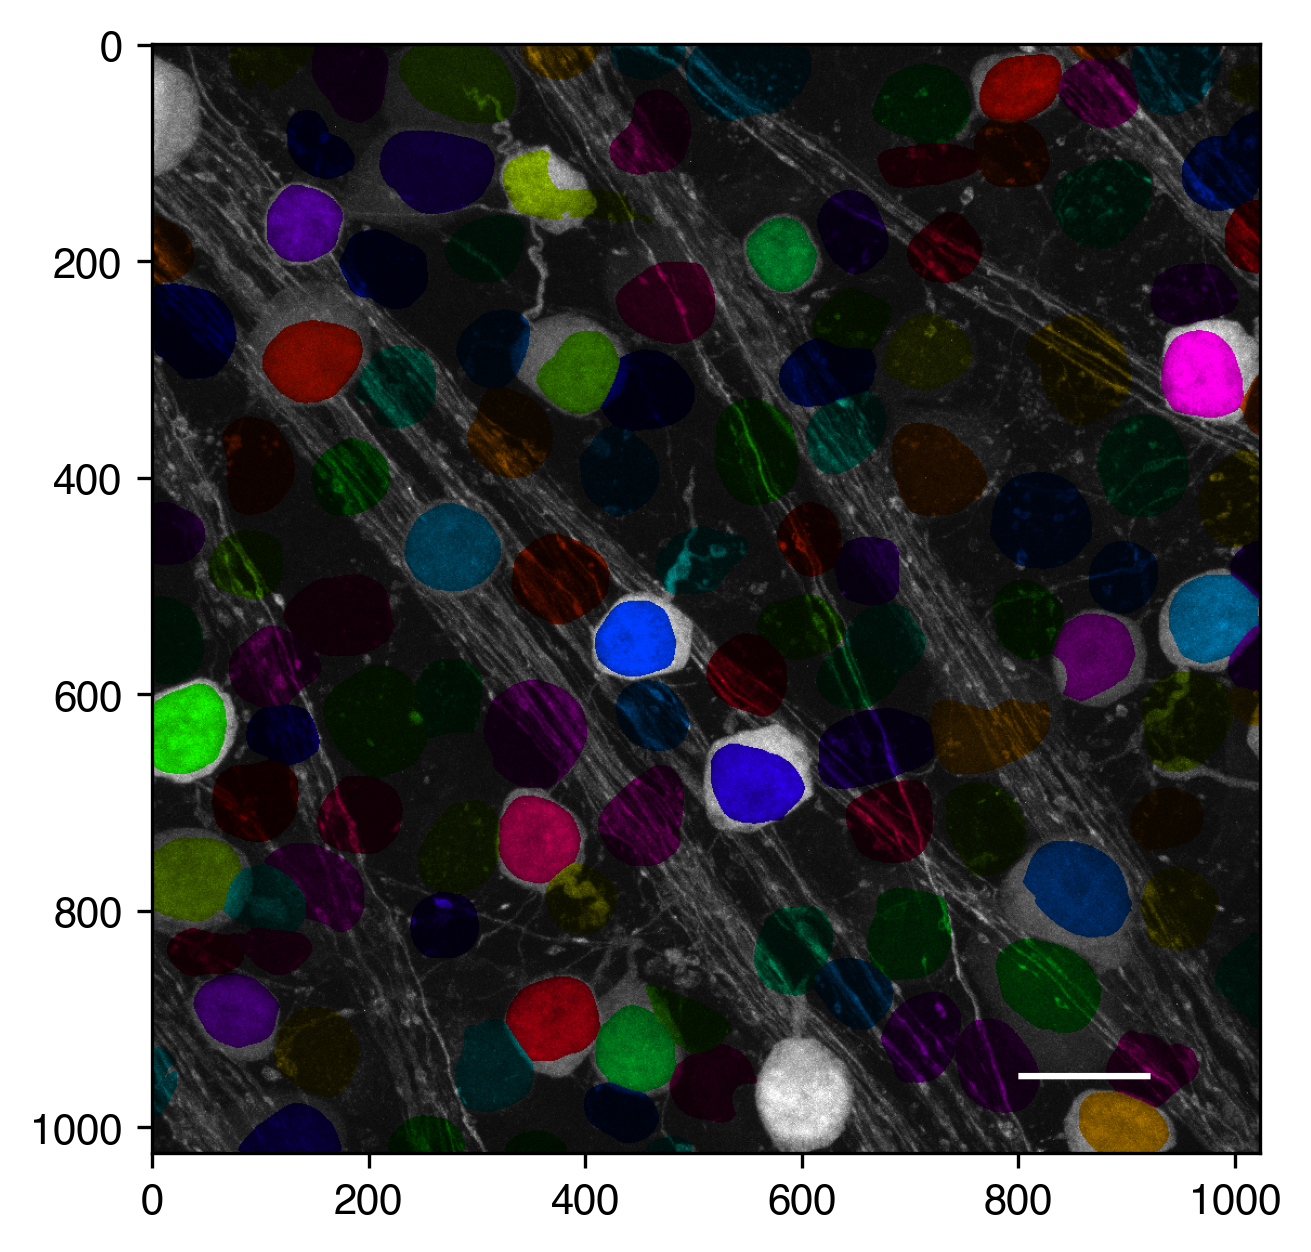

In [89]:
ov1 = plot.mask_overlay(max_proj(image[:,1, :, :]), DAPI_masks)
plt.imshow(add_scale_bar(ov1, .123, 15, 800, 950))

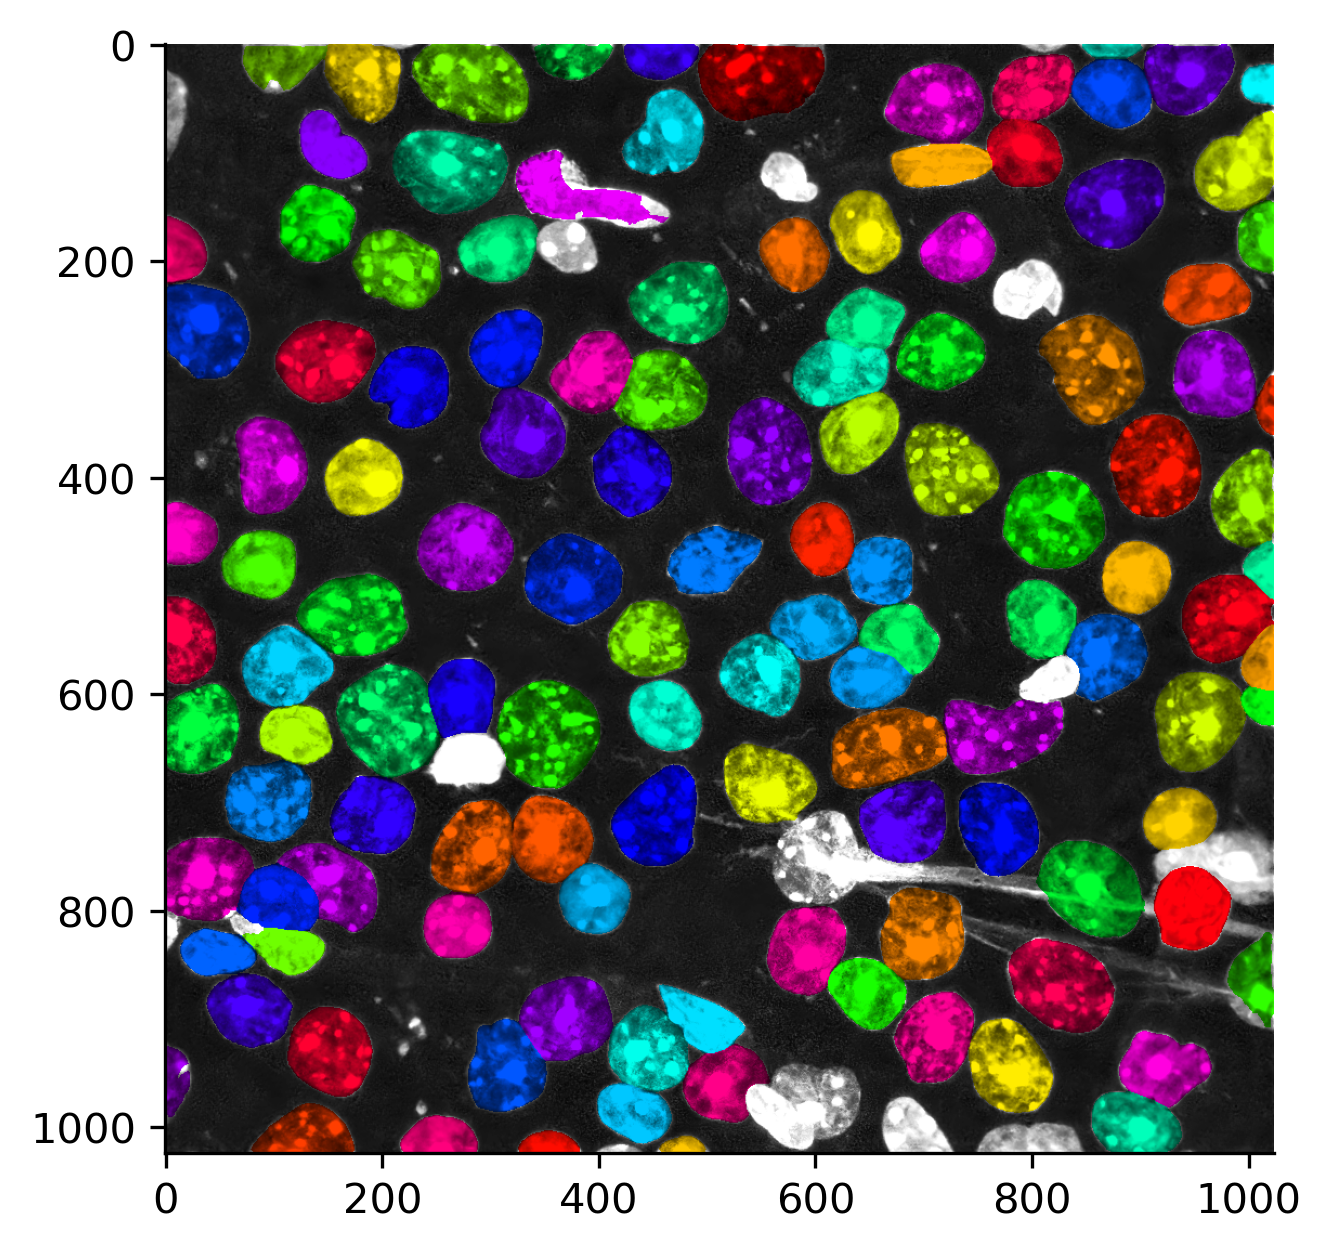

In [153]:
plt.imshow(plot.mask_overlay(to_8bit(image_deblurred), DAPI_masks))